<a href="https://colab.research.google.com/github/vincentzouras/cse337/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


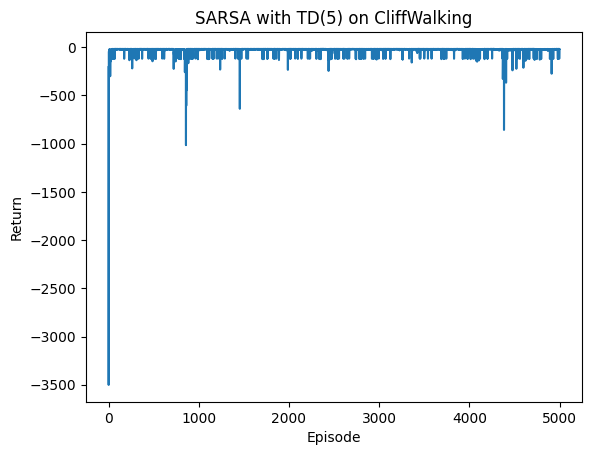

In [1]:
"""
Starter code for Exercise (you can use this code, or extend your code from previous lab)
Implement SARSA with TD(5) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1")

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.1         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 5000

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns = []

for ep in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state)

    # Buffers to store the trajectory
    states = deque()
    actions = deque()
    rewards = deque()

    T = float("inf") # time step when episode terminates
    t = 0 # current time step
    G = 0 # n-step return (cumulative reward)
    done = False

    while True:
        if t < T:
            # Take real step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(state)
            actions.append(action)
            rewards.append(reward)

            if done:
                T = t + 1
            else:
                next_action = epsilon_greedy(next_state)
                state = next_state
                action = next_action

        # Time index for state/action to update
        tau = t - n_step
        if tau >= 0:
            # TODO: Compute the n-step return G for state tau
            # Hint: use rewards[tau : tau+n] plus Q(s_t+n, a_t+n) if not terminal

            # Example structure:
            G = 0.0
            # accumulate discounted rewards
            for i in range(tau, min(tau + n_step, T)):
                G += (gamma ** (i - tau)) * rewards[i]
            if tau + n_step < T:
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # TODO: Update Q[states[tau], actions[tau]] toward G
            Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

        if tau == T - 1:
            break

        t += 1

    episode_returns.append(sum(rewards))

# Plot learning curve
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA with TD(5) on CliffWalking")
plt.show()


### Does n-step SARSA converge faster or slower?
N step sarsa converges faster because it is taking more steps to calculate future rewards, which results in less bias because it isn't basing its entire reward estimation on only a single guess. So it will converge faster, but this comes at the expense of variance because it will fluctuate more between episodes.
### How do the policies differ near the cliff?
The n step sarsa becomes worse near the cliff because of the higher variance, which results in greater deviations and steps off the cliff despite the overall policy being more accurate faster.

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




Running SARSA (1-step)...
Running N-step SARSA (n=5)...
Running Dyna-Q (n=5)...
Running Dyna-Q (n=20)...
Running Dyna-Q (n=50)...


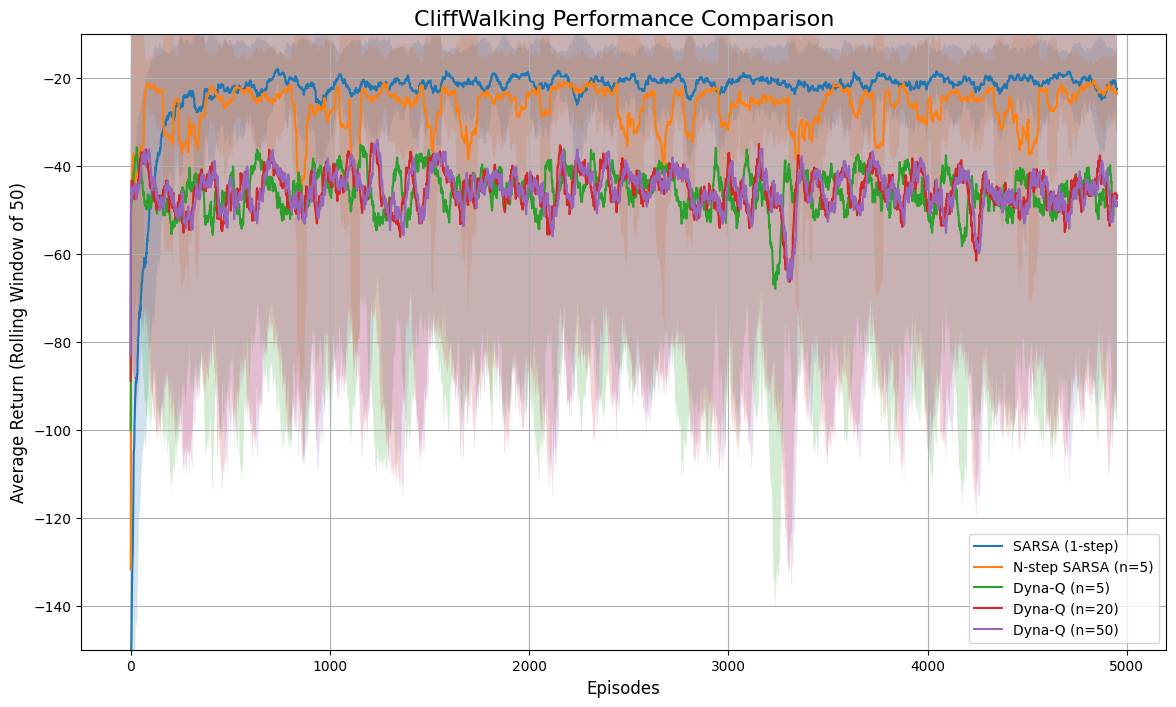

In [15]:
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import random

def epsilon_greedy(Q, state, epsilon, n_actions):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])


# Algorithm implementations

def dyna_q(env, n_episodes, alpha, gamma, epsilon, n_planning_steps):
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    Q = np.zeros((n_states, n_actions))
    model = {}
    episode_returns = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        terminated = False
        truncated = False
        total_reward = 0

        while not terminated and not truncated:
            action = epsilon_greedy(Q, state, epsilon, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)

            # 1. Direct RL update (Q learning)
            Q[state, action] = Q[state, action] + alpha * (reward + (gamma * np.max(Q[next_state]) - Q[state, action]))

            # 2. Model learning
            model[(state, action)] = (reward, next_state)

            # 3. Planning
            for _ in range(n_planning_steps):
                # Sample previously seen state-action pair
                prev_state, prev_action = random.choice(list(model.keys()))
                prev_reward, prev_next_state = model[(prev_state, prev_action)]

                # Q learning on imagination
                Q[prev_state, prev_action] = Q[prev_state, prev_action] + alpha * (prev_reward + (gamma * np.max(Q[prev_next_state]) - Q[prev_state, prev_action]))

            state = next_state
            total_reward += reward

        episode_returns.append(total_reward)
    return episode_returns

def sarsa(env, n_episodes, alpha, gamma, epsilon):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    episode_returns = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon, n_actions)
        terminated, truncated = False, False
        total_reward = 0

        while not terminated and not truncated:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon, n_actions)

            # SARSA Update
            td_target = reward + gamma * Q[next_state, next_action]
            Q[state, action] += alpha * (td_target - Q[state, action])

            state = next_state
            action = next_action
            total_reward += reward

        episode_returns.append(total_reward)
    return episode_returns

def n_step_sarsa(env, n_episodes, n, alpha, gamma, epsilon):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    episode_returns = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon, n_actions)

        # Use lists for the trajectory to allow for indexing
        states = [state]
        actions = [action]
        rewards = []

        T = float("inf")
        t = 0

        while True:
            if t < T:
                next_state, reward, terminated, truncated, _ = env.step(action)
                rewards.append(reward)

                if terminated or truncated:
                    T = t + 1
                else:
                    next_action = epsilon_greedy(Q, next_state, epsilon, n_actions)
                    states.append(next_state)
                    actions.append(next_action)
                    action = next_action # Update for the next loop iteration

            # Time index for the state/action to update
            tau = t - n + 1
            if tau >= 0:
                G = 0.0
                # Accumulate discounted rewards
                for i in range(tau, min(tau + n, T)):
                    # Index rewards from the start of the trajectory slice
                    G += (gamma ** (i - tau)) * rewards[i]

                if tau + n < T:
                    s_tau_n = states[tau + n]
                    a_tau_n = actions[tau + n]
                    G += (gamma ** n) * Q[s_tau_n, a_tau_n]

                # Update Q-value
                s_tau = states[tau]
                a_tau = actions[tau]
                Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

            if tau == T - 1:
                break

            t += 1

        episode_returns.append(sum(rewards))
    return episode_returns


# Environment
env = gym.make("CliffWalking-v1")

# Parameters
N_EPISODES = 5000
N_SEEDS = 5
ALPHA = 0.1
GAMMA = 0.99
EPSILON = 0.1

# Experiment Configuration
experiments = {
    "SARSA (1-step)": lambda: sarsa(env, N_EPISODES, ALPHA, GAMMA, EPSILON),
    "N-step SARSA (n=5)": lambda: n_step_sarsa(env, N_EPISODES, 5, ALPHA, GAMMA, EPSILON),
    "Dyna-Q (n=5)": lambda: dyna_q(env, N_EPISODES, ALPHA, GAMMA, EPSILON, 5),
    "Dyna-Q (n=20)": lambda: dyna_q(env, N_EPISODES, ALPHA, GAMMA, EPSILON, 20),
    "Dyna-Q (n=50)": lambda: dyna_q(env, N_EPISODES, ALPHA, GAMMA, EPSILON, 50),
}

# Run Experiments
results = {}
for name, run_func in experiments.items():
    print(f"Running {name}...")
    all_seed_returns = []
    for seed in range(N_SEEDS):
        random.seed(seed)
        np.random.seed(seed)
        all_seed_returns.append(run_func())
    results[name] = np.array(all_seed_returns)

env.close()

# Plot Results
def plot_results(results, title):
    """Plots the mean and standard deviation of returns for each algorithm."""
    plt.figure(figsize=(14, 8))

    # Use a rolling average for smoother curves
    window_size = 50

    for name, returns_over_seeds in results.items():
        # Calculate mean and std deviation over seeds
        mean_returns = np.mean(returns_over_seeds, axis=0)
        std_returns = np.std(returns_over_seeds, axis=0)

        # Smooth the curves
        rolling_mean = np.convolve(mean_returns, np.ones(window_size)/window_size, mode='valid')
        rolling_std = np.convolve(std_returns, np.ones(window_size)/window_size, mode='valid')

        x_axis = np.arange(len(rolling_mean))
        plt.plot(x_axis, rolling_mean, label=name)
        plt.fill_between(x_axis, rolling_mean - rolling_std, rolling_mean + rolling_std, alpha=0.2)

    plt.title(title, fontsize=16)
    plt.xlabel("Episodes", fontsize=12)
    plt.ylabel(f"Average Return (Rolling Window of {window_size})", fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.ylim(-150, -10) # Set y-axis for better visualization
    plt.show()
plot_results(results, "CliffWalking Performance Comparison")

## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- **Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
